<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/sgrepo/floorplandetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

In [ ]:
!git clone https://github.com/rbg-research/Floor-Plan-Detection.git
%cd Floor-Plan-Detection

In [ ]:
import os

#downloading weights

!gdown 'https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK'

In [ ]:
#downloading blender

blender_url =  "https://ftp.nluug.nl/pub/graphics/blender/release/Blender2.93/blender-2.93.1-linux-x64.tar.xz"
base_url = os.path.basename(blender_url)
blender_version="blender2.93"
!mkdir $blender_version
!wget -nc $blender_url
!tar -xkf $base_url -C ./$blender_version --strip-components=1
!rm blender-2.93.1-linux-x64.tar.xz

In [ ]:
!pip install pyfiglet
!pip install lmdb svgpathtools

prepare Demo data

In [1]:
# !wget https://cdn.img-asp.jp/cms/51033_2_480_1000_1.jpg -O /content/madori.jpg
!wget https://suumo.jp/article/oyakudachi/wp-content/uploads/2019/03/madorizu_sub04.jpg -O /content/madori.jpg

--2023-06-30 08:21:43--  https://suumo.jp/article/oyakudachi/wp-content/uploads/2019/03/madorizu_sub04.jpg
Resolving suumo.jp (suumo.jp)... 160.17.3.13
Connecting to suumo.jp (suumo.jp)|160.17.3.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124710 (122K) [image/jpeg]
Saving to: ‘/content/madori.jpg’

/content/madori.jpg 100%[===================>] 121.79K   547KB/s    in 0.2s    

2023-06-30 08:21:43 (547 KB/s) - ‘/content/madori.jpg’ saved [124710/124710]



Inference

In [4]:
%cd /content/Floor-Plan-Detection

/content/Floor-Plan-Detection


In [5]:
# Add outer folder
# Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *

# Other necessary libraries
import numpy as np

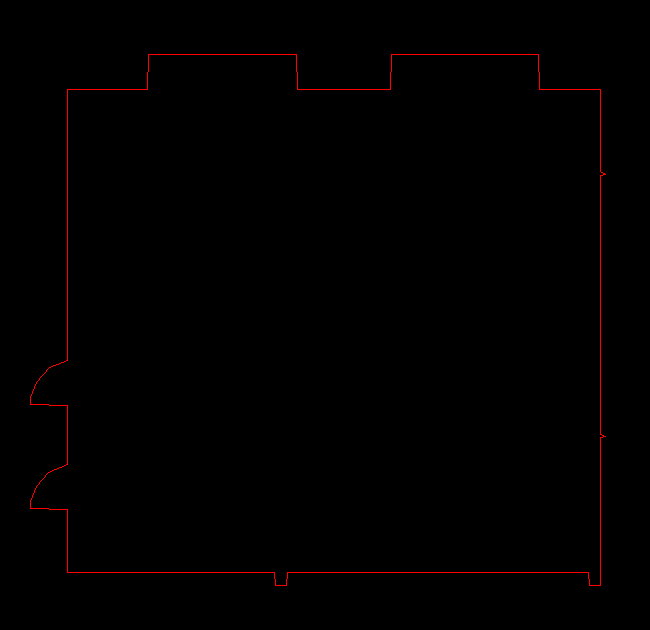

In [6]:
# Import library
from utils.FloorplanToBlenderLib import *

import cv2 # for image gathering
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display

img_path = "/content/madori.jpg"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, img = detect.detectOuterContours(gray, blank_image, color=(255,0,0))

# Display
display(Image.fromarray(img))

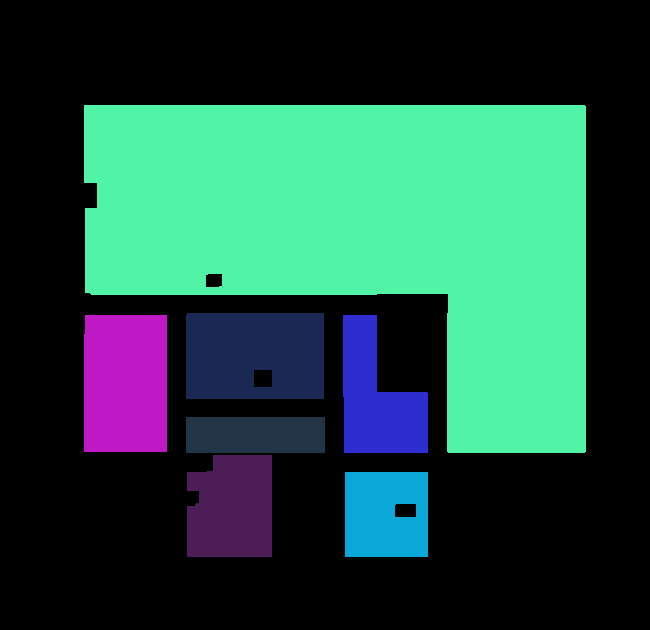

In [7]:
img = cv2.imread(img_path)

    # grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
height = 0.999

# Scale pixel value to 3d pos
scale = 100

gray = detect.wall_filter(gray)

gray = ~gray

rooms, colored_rooms = detect.find_rooms(gray.copy())

gray_rooms =  cv2.cvtColor(colored_rooms,cv2.COLOR_BGR2GRAY)

# get box positions for rooms
boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
display(Image.fromarray(colored_rooms))

 #Create verts
room_count = 0
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, height)])
    room_count+= 1

# create faces
for room in verts:
    count = 0
    temp = ()
    for pos in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

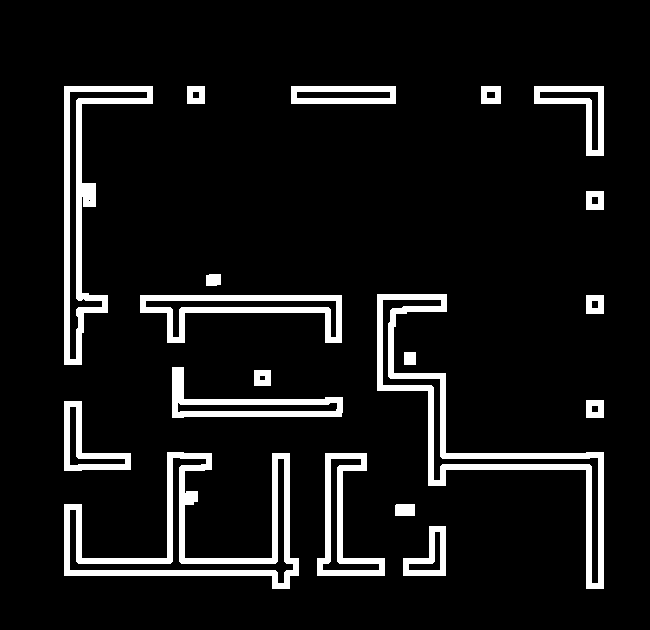

In [8]:
'''
    Generate wall data file for floorplan
    @Param img_path, path to input file
    @Param info, boolean if data should be printed
    @Return shape
    '''
from utils.FloorplanToBlenderLib import *
# Read floorplan image
img = cv2.imread(img_path)

# grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create wall image (filter out small objects from image)
wall_img = detect.wall_filter(gray)

# detect walls
boxes, img = detect.detectPreciseBoxes(wall_img)

display(Image.fromarray(wall_img))

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
wall_height = 1

# Scale pixel value to 3d pos
scale = 100

# Convert boxes to verts and faces
verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

In [9]:
%cd /content/Floor-Plan-Detection/

/content/Floor-Plan-Detection


In [ ]:
# utils/plotting.pyの610, 611行目をコメントアウトする。

In [10]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
import cv2
from torch.utils.data import DataLoader

from model import get_model
from utils.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from utils.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict,           discrete_cmap
discrete_cmap()
from utils.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath",
                "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink",
                "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

model = get_model('hg_furukawa_original', 51)
n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()

hg_furukawa_original(
  (conv1_): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (r01): Residual(
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (r02): Residual(
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

In [11]:
img_path = "/content/madori.jpg"
# Create tensor for pytorch
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # correct color channels

# Image transformation to range (-1,1)
img = 2 * (img / 255.0) - 1

# Move from (h,w,3)--->(3,h,w) as model input dimension is defined like this
img = np.moveaxis(img, -1, 0)

# Convert to pytorch, enable cuda
img = torch.tensor([img.astype(np.float32)]).cuda()
n_rooms = 12
n_icons = 11

with torch.no_grad():
    #Check if shape of image is odd or even
    size_check = np.array([img.shape[2],img.shape[3]])%2

    height = img.shape[2] - size_check[0]
    width = img.shape[3] - size_check[1]

    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(img, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)


rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

wall_polygon_numbers=[i for i,j in enumerate(types) if j['type']=='wall']
boxes=[]
for i,j in enumerate(polygons):
    if i in wall_polygon_numbers:
        temp=[]
        for k in j:
            temp.append(np.array([k]))
        boxes.append(np.array(temp))


# Scale pixel value to 3d pos
scale = 100
# Height of waLL
wall_height = 1
# Scale pixel value to 3d pos
scale = 100

verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

<ipython-input-11-2a54b4cbe2b4>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  img = torch.tensor([img.astype(np.float32)]).cuda()
/content/Floor-Plan-Detection/utils/post_prosessing.py:948: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  wall_width = stats.mode(widths).mode[0]
/content/Floor-Plan-Detection/utils/post_prosessing.py:1004: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), th

/usr/local/lib/python3.10/dist-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


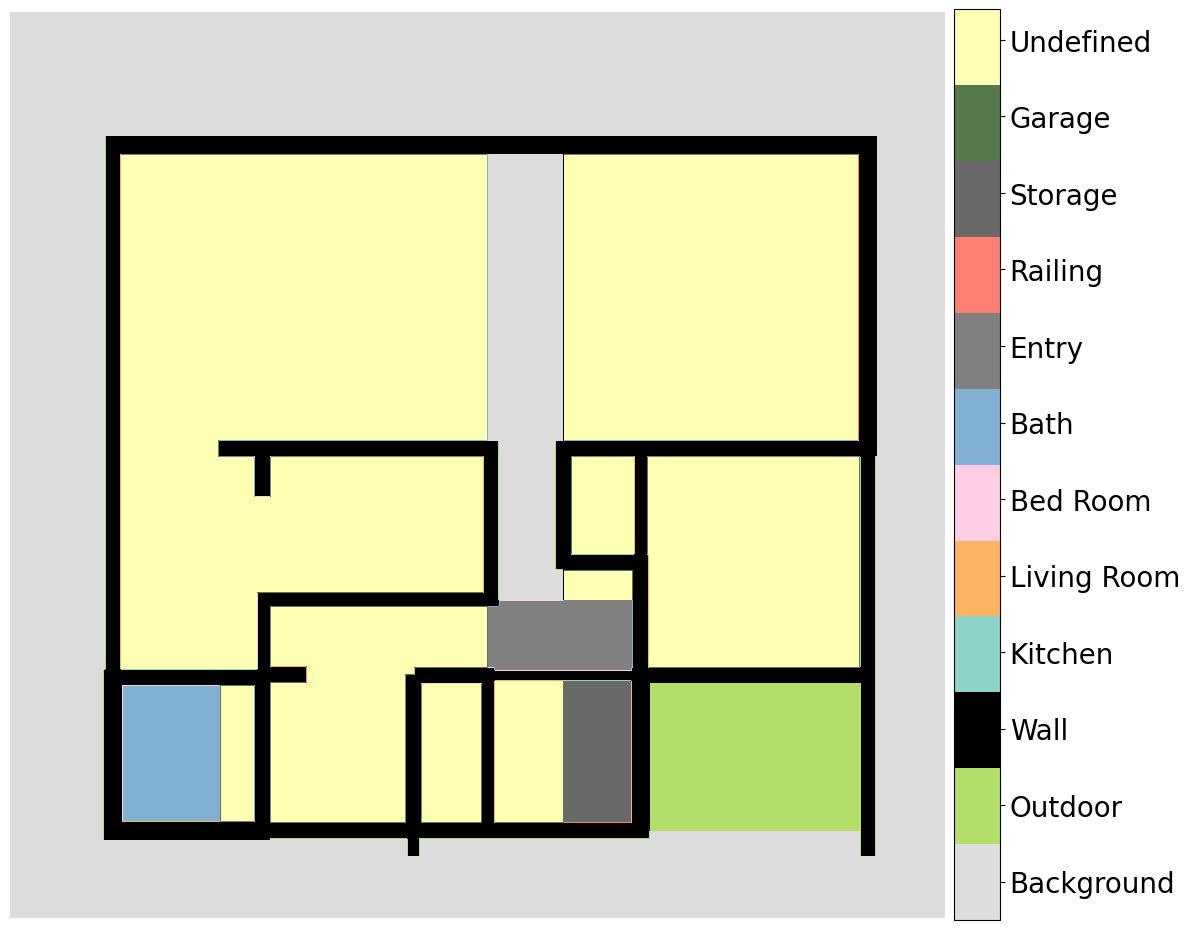

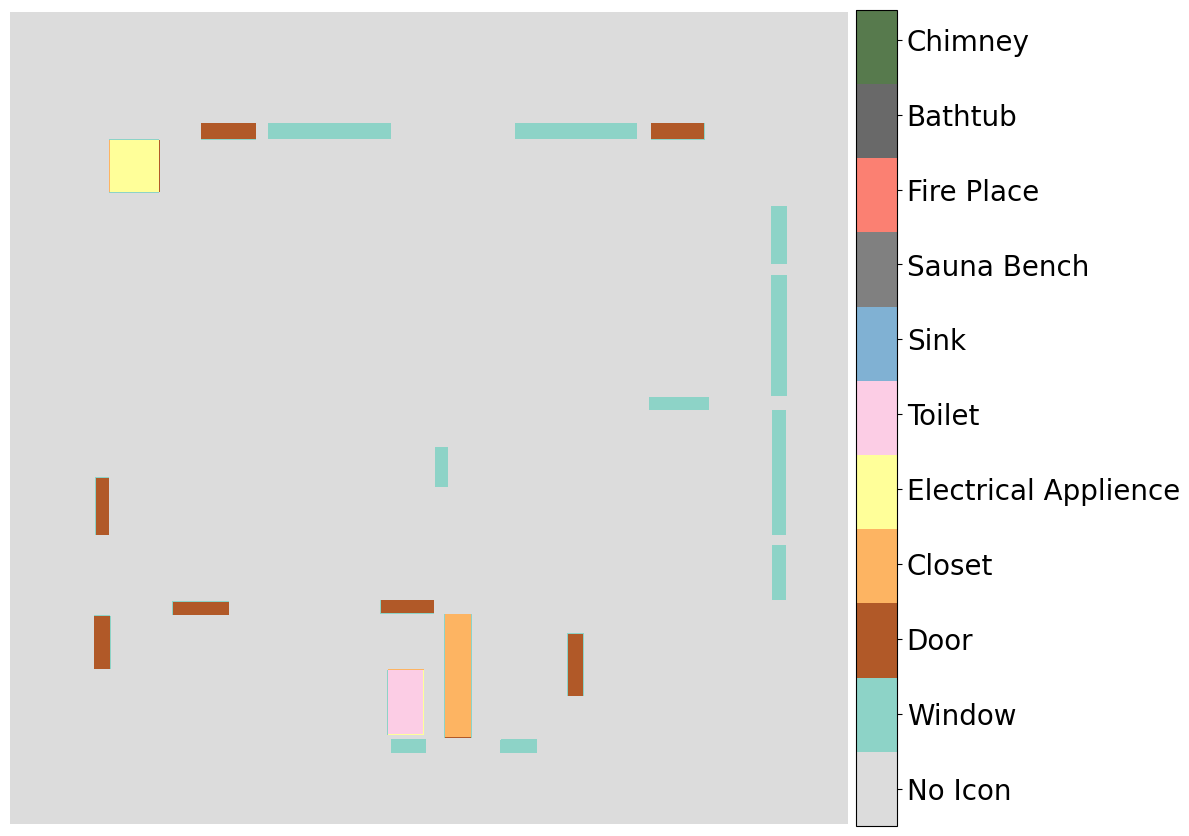

In [12]:
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)


plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

In [13]:
%cd /content/Floor-Plan-Detection

/content/Floor-Plan-Detection


In [ ]:
# config.py
"""
import os

image_path = '/content/madori.jpg'
target_path = '/floorplan' # will export in two formats (.blend and .stl)
program_path = os.getcwd()
blender_install_path = program_path+"/blender2.93/blender"
blender_script_path = program_path+"/floorplan_to_3dObject_in_blender.py"

SR_scale = 2
SR_method = 'lapsrn'

CubiCasa = True
"""

In [ ]:
# FloorplanToSTL.py
"""
from utils.FloorplanToBlenderLib import *
from subprocess import check_output
import os
import config

def createFloorPlan(image_path = config.image_path, target_path = config.target_path, SR_Check=True):

    SR= [config.SR_scale,config.SR_method]
    program_path = config.program_path
    blender_install_path = config.blender_install_path
    blender_script_path = config.blender_script_path
    CubiCasa = config.CubiCasa
    data_paths = [execution.simple_single(image_path,CubiCasa,SR)]

    check_output([blender_install_path,
     "-noaudio", # this is a dockerfile ubuntu hax fix
     "--background",
     "--python",
     blender_script_path,
     program_path, # Send this as parameter to script
     target_path
     ] +  data_paths)

    print("Created File at "+target_path)
"""

In [14]:
import FloorplanToSTL as stl
import config

# can specify or use default paths in config files
stl.createFloorPlan(image_path = config.image_path, target_path = config.target_path, SR_Check=True)

# Note: USE SR_Check = False for Original Image

 ----- Generate  /content/madori.jpg  at pos  None  rot  None  -----
Approximated apartment size :  270588.5
Created file : Data/3/floor_verts.txt
Created file : Data/3/floor_faces.txt
Walls created :  179
Created file : Data/3/wall_verts.txt
Created file : Data/3/wall_faces.txt
Created file : Data/3/top_wall_verts.txt
Created file : Data/3/top_wall_faces.txt
Number of rooms detected :  7
Created file : Data/3/rooms_verts.txt
Created file : Data/3/rooms_faces.txt
Created file : Data/3/transform.txt
Created File at /floorplan


In [ ]:
# download stl floorplan.stl